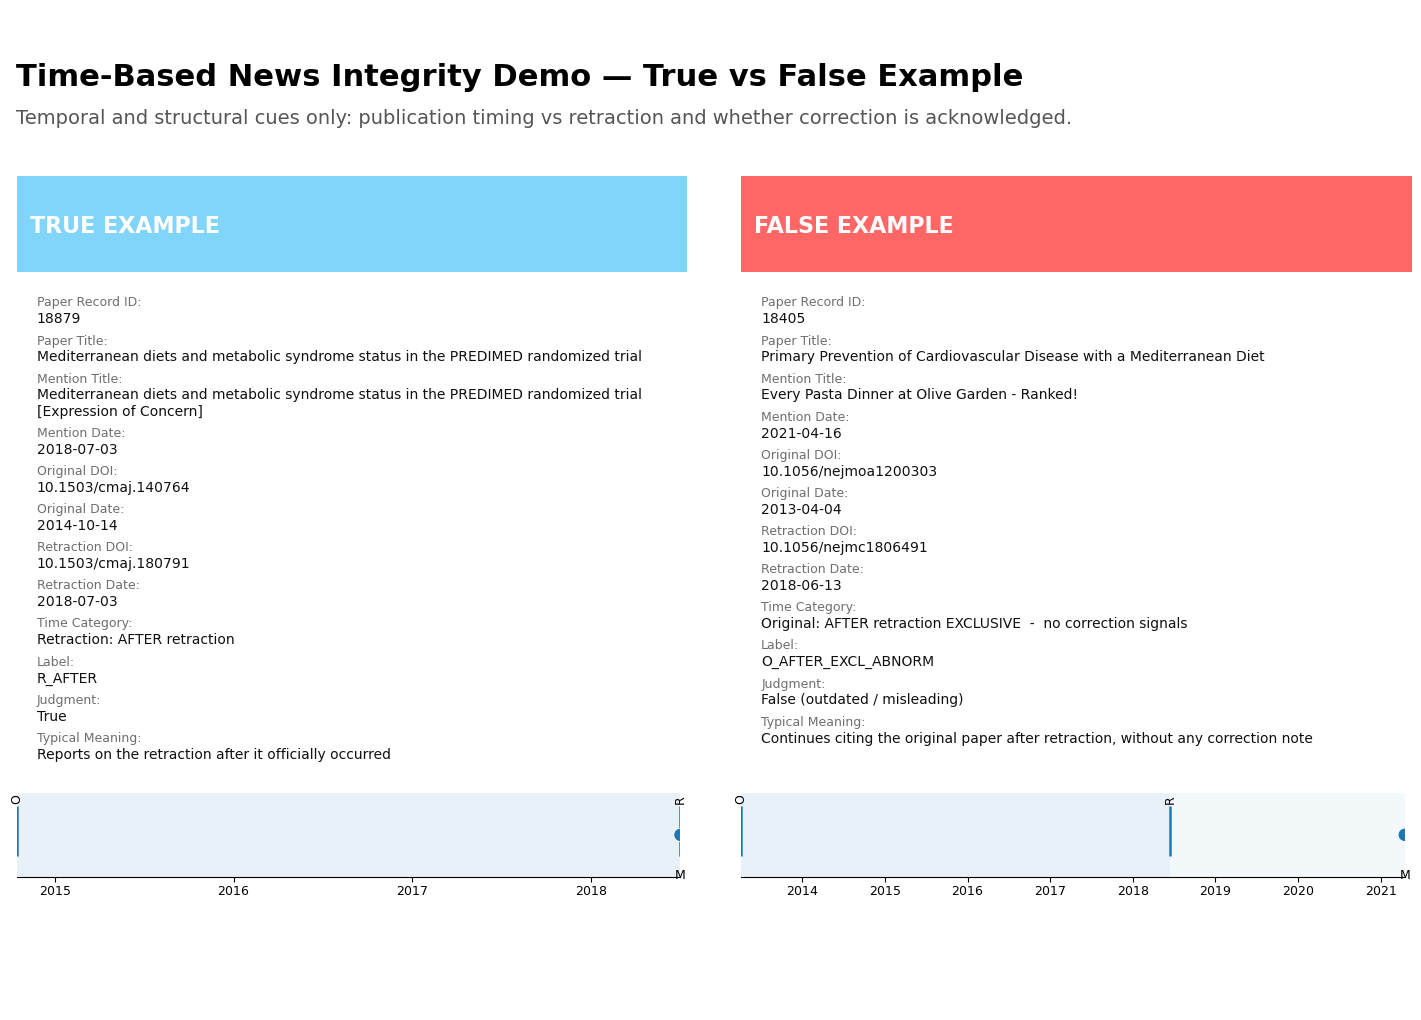

Saved figure to: /Users/miaoyixuan/CS58/demo_outputss/true_false_demo_final_fulltext.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker
from pathlib import Path
import textwrap
from urllib.parse import urlparse

PATH_MASTER    = "dataset_14_08_2025_completion.csv"
PATH_O_LABELED = "mentions_original_label.csv"
PATH_R_LABELED = "mentions_retraction_label.csv"
OUTDIR = Path("demo_outputss"); OUTDIR.mkdir(exist_ok=True)

USE_FIXED_SEED = False
RANDOM_SEED    = 42

FIG_SIZE       = (18, 13)
FONT_SIZE_VAL  = 10
FONT_SIZE_KEY  = 9
BANNER_TRUE    = "#81D4FA"
BANNER_FALSE   = "#FF6666"

WRAP_WIDTH_DEFAULT = 90
WRAP_WIDTH_LONG    = 90
MAX_LINES_TRUNC    = 5

SHOW_PAPER_TITLE           = True
SHOW_MENTION_TITLE         = True
SHOW_RESEARCH_OUTPUT_TITLE = False
SHOW_MENTION_URL           = False

TIMELINE_BOX = [0.0, 0.16, 0.99, 0.1]

def norm_str(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    return np.nan if x in {"", "0", "nan", "NaN", "none", "None", "null", "Null"} else x

def norm_doi(x):
    x = norm_str(x)
    if pd.isna(x): return np.nan
    x = x.lower()
    if x.startswith("doi:"):
        x = x[4:].strip()
    return x

def canonical_url(u):
    u = norm_str(u)
    if pd.isna(u): return np.nan
    if "#" in u: u = u.split("#", 1)[0]
    return u

def to_dt(x):
    return pd.to_datetime(x, errors="coerce", utc=True)

def make_unique_map(df, key_col, cols_to_keep):
    use = df.dropna(subset=[key_col]).copy()
    use = use.drop_duplicates(subset=[key_col], keep="first")
    return use.set_index(key_col)[cols_to_keep].to_dict(orient="index")

def dedupe_columns(df):
    return df.loc[:, ~df.columns.duplicated()]

def get_first_column(df, name):
    matches = np.where(df.columns == name)[0]
    if len(matches) == 0:
        raise KeyError(f"Column '{name}' not found")
    return df.iloc[:, matches[0]]

def _to_naive(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return pd.NaT
    ts = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(ts): return pd.NaT
    return ts.tz_convert(None)

def _fmt_date_str(x):
    ts = _to_naive(x)
    return "—" if pd.isna(ts) else ts.strftime("%Y-%m-%d")

def wrap_text_trunc(s, width=WRAP_WIDTH_DEFAULT, max_lines=MAX_LINES_TRUNC):
    s = "" if s is None else str(s)
    s = s.replace("—", " - ")
    lines = textwrap.wrap(s, width=width, break_long_words=False, break_on_hyphens=False)
    if len(lines) > max_lines:
        j = " ".join(lines[:max_lines]).rstrip() + "…"
        return j
    return "\n".join(lines)

def wrap_text_full(s, width=WRAP_WIDTH_LONG):
    s = "" if s is None else str(s)
    s = s.replace("—", " - ")
    lines = textwrap.wrap(s, width=width, break_long_words=False, break_on_hyphens=False)
    return "\n".join(lines)

def label_to_meta(lbl):
    meta = {
        "O_BEFORE": ("Original: BEFORE retraction",
                     "News or blogs reporting the original paper before it was officially retracted",
                     "True"),
        "O_AFTER_COMENTION": ("Original: AFTER retraction + Retraction co-mention",
                              "The same article mentions both the original and the retraction",
                              "True (corrective / explanatory)"),
        "O_AFTER_EXCL_NORM": ("Original: AFTER retraction EXCLUSIVE — with correction signals",
                              "News continues to cite the original paper after retraction but includes a notice",
                              "True (corrective / updated)"),
        "O_AFTER_EXCL_ABNORM": ("Original: AFTER retraction EXCLUSIVE — no correction signals",
                                "Continues citing the original paper after retraction, without any correction note",
                                "False (outdated / misleading)"),
        "R_AFTER": ("Retraction: AFTER retraction",
                    "Reports on the retraction after it officially occurred",
                    "True"),
        "R_BEFORE_COMENTION": ("Retraction: BEFORE retraction + Original co-mention",
                               "A retraction is mentioned together with the original paper before the formal retraction date",
                               "True (tracking / clarification)"),
        "R_BEFORE_EXCL_ABNORM": ("Retraction: BEFORE retraction EXCLUSIVE — with validation signals",
                                 "Reports a retraction before the official date, but the information is later verified",
                                 "True (verified / clarified)"),
        "R_BEFORE_EXCL_NORM": ("Retraction: BEFORE retraction EXCLUSIVE — no validation signals",
                               "Claims a retraction before it actually happens, without subsequent verification",
                               "False (premature / speculative)")
    }
    return meta.get(lbl, ("Unknown", "—", "Unknown"))

master = pd.read_csv(PATH_MASTER, dtype=str, keep_default_na=False)
for c in ["OriginalPaperDate", "RetractionDate"]:
    master[c] = to_dt(master.get(c))
master["orig_doi_norm"] = master.get("OriginalPaperDOI", "").map(norm_doi)
master["retr_doi_norm"] = master.get("RetractionDOI", "").map(norm_doi)

map_orig_to = make_unique_map(
    master, "orig_doi_norm",
    ["Record ID","OriginalPaperDate","RetractionDate","RetractionDOI","Title"]
)
map_retr_to = make_unique_map(
    master, "retr_doi_norm",
    ["Record ID","OriginalPaperDate","RetractionDate","OriginalPaperDOI","Title"]
)

o = pd.read_csv(PATH_O_LABELED, dtype=str, keep_default_na=False)
r = pd.read_csv(PATH_R_LABELED, dtype=str, keep_default_na=False)
for df in (o, r):
    df["Mention Date"] = to_dt(df["Mention Date"])
    df["Mention URL"]  = df.get("Mention URL", "").map(canonical_url)
    if "DOI_norm" not in df.columns:
        df["DOI_norm"] = df.get("DOI", "").map(norm_doi)

def attach_paper_info(df, side):
    rows = []
    for doi in df["DOI_norm"]:
        if side == "orig":
            d = map_orig_to.get(doi)
            if d is None:
                rows.append({"Paper Record ID": np.nan, "Original DOI": doi, "Retraction DOI": np.nan,
                             "OriginalPaperDate": pd.NaT, "Retraction Date": pd.NaT, "Title": np.nan})
            else:
                rows.append({
                    "Paper Record ID": d.get("Record ID"),
                    "Original DOI": doi,
                    "Retraction DOI": norm_doi(d.get("RetractionDOI")),
                    "OriginalPaperDate": d.get("OriginalPaperDate"),
                    "Retraction Date": d.get("RetractionDate"),
                    "Title": d.get("Title")
                })
        else:
            d = map_retr_to.get(doi)
            if d is None:
                rows.append({"Paper Record ID": np.nan, "Original DOI": np.nan, "Retraction DOI": doi,
                             "OriginalPaperDate": pd.NaT, "Retraction Date": pd.NaT, "Title": np.nan})
            else:
                rows.append({
                    "Paper Record ID": d.get("Record ID"),
                    "Original DOI": norm_doi(d.get("OriginalPaperDOI")),
                    "Retraction DOI": doi,
                    "OriginalPaperDate": d.get("OriginalPaperDate"),
                    "Retraction Date": d.get("RetractionDate"),
                    "Title": d.get("Title")
                })
    extra = pd.DataFrame(rows)
    return pd.concat([df.reset_index(drop=True), extra], axis=1)

o_enriched = attach_paper_info(o, "orig")
r_enriched = attach_paper_info(r, "retr")

def add_meta(df, source):
    metas = df["label"].map(lambda x: pd.Series(label_to_meta(x),
                                                index=["Time Category","Typical Meaning","Judgment"]))
    metas["Source"] = source
    out = pd.concat([df.reset_index(drop=True), metas], axis=1)
    return dedupe_columns(out)

o_meta = add_meta(o_enriched, "Original")
r_meta = add_meta(r_enriched, "Retraction")

all_mentions = pd.concat([o_meta, r_meta], ignore_index=True)
all_mentions = dedupe_columns(all_mentions)
label_series = get_first_column(all_mentions, "label").astype(str)

true_labels  = {"O_BEFORE","O_AFTER_COMENTION","O_AFTER_EXCL_NORM","R_AFTER","R_BEFORE_COMENTION","R_BEFORE_EXCL_NORM"}
false_labels = {"O_AFTER_EXCL_ABNORM","R_BEFORE_EXCL_ABNORM"}

all_mentions["is_true"]  = label_series.isin(true_labels)
all_mentions["is_false"] = label_series.isin(false_labels)

true_pool  = all_mentions[all_mentions["is_true"]].copy()
false_pool = all_mentions[all_mentions["is_false"]].copy()
if true_pool.empty or false_pool.empty:
    raise RuntimeError("No rows to sample. Check label values in labeled CSVs.")

_rand_state = (np.random.RandomState(RANDOM_SEED) if USE_FIXED_SEED else None)
true_row  = true_pool.sample(1, random_state=_rand_state).iloc[0]
false_row = false_pool.sample(1, random_state=_rand_state).iloc[0]

def build_info_from_row(row):
    lbl = str(row.get("label", ""))
    time_cat, meaning, judge = label_to_meta(lbl)

    paper_title     = wrap_text_full(row.get("Title", ""),                  width=WRAP_WIDTH_LONG) if SHOW_PAPER_TITLE else None
    mention_title   = wrap_text_full(row.get("Mention Title", ""),          width=WRAP_WIDTH_LONG) if SHOW_MENTION_TITLE else None
    research_title  = wrap_text_full(row.get("Research Output Title", ""),  width=WRAP_WIDTH_LONG) if SHOW_RESEARCH_OUTPUT_TITLE else None
    if SHOW_MENTION_URL:
        u = row.get("Mention URL", "")
        if isinstance(u, str) and u:
            try:
                p = urlparse(u)
                base = f"{p.netloc}{p.path}"
            except Exception:
                base = u
        else:
            base = ""
        mention_url = wrap_text_full(base, width=WRAP_WIDTH_LONG)
    else:
        mention_url = None

    return {
        "Paper Record ID": str(row.get("Paper Record ID", "")),
        "Paper Title": paper_title,
        "Mention Title": mention_title,
        "Research Output Title": research_title,
        "Mention Date": _fmt_date_str(row.get("Mention Date")),
        "Mention URL": mention_url,
        "Original DOI": wrap_text_trunc(row.get("Original DOI", ""), width=WRAP_WIDTH_DEFAULT, max_lines=4),
        "Original Date": _fmt_date_str(row.get("OriginalPaperDate")),
        "Retraction DOI": wrap_text_trunc(row.get("Retraction DOI", ""), width=WRAP_WIDTH_DEFAULT, max_lines=4),
        "Retraction Date": _fmt_date_str(row.get("Retraction Date")),
        "Time Category": wrap_text_trunc(time_cat, width=WRAP_WIDTH_DEFAULT, max_lines=3),
        "Label": lbl,
        "Judgment": judge,
        "Typical Meaning": wrap_text_trunc(meaning, width=WRAP_WIDTH_DEFAULT, max_lines=4),
    }

true_info  = build_info_from_row(true_row)
false_info = build_info_from_row(false_row)

def draw_card(ax, info, banner, banner_color, src_row):
    ax.axis("off")
    ax.add_patch(plt.Rectangle((0,0.885), 1, 0.115, transform=ax.transAxes, color=banner_color, ec="none"))
    ax.text(0.02, 0.94, banner, transform=ax.transAxes, va="center", ha="left",
            fontsize=16, color="white", fontweight="bold")

    entries = []
    label_color = "#6e6e6e"
    value_color = "#101010"

    ordered_keys = [
        "Paper Record ID",
        "Paper Title",
        "Mention Title",
        "Research Output Title",
        "Mention URL",
        "Mention Date","Original DOI","Original Date","Retraction DOI","Retraction Date",
        "Time Category","Label","Judgment","Typical Meaning"
    ]

    for k in ordered_keys:
        v = info.get(k, None)
        if v is None or str(v).strip() == "":
            continue
        label_box = TextArea(f"{k}:", textprops=dict(color=label_color, fontsize=FONT_SIZE_KEY))
        value_box = TextArea(v,          textprops=dict(color=value_color, fontsize=FONT_SIZE_VAL))
        vbox = VPacker(children=[label_box, value_box], align="left", pad=0, sep=2)
        entries.append(vbox)

    text_stack = VPacker(children=entries, align="left", pad=5, sep=6)
    anchored_box = AnchoredOffsetbox(
        loc="upper left", child=text_stack, pad=0, frameon=False,
        bbox_to_anchor=(0.02,0.865), bbox_transform=ax.transAxes, borderpad=0.
    )
    ax.add_artist(anchored_box)

    t_orig = _to_naive(src_row.get("OriginalPaperDate"))
    t_ret  = _to_naive(src_row.get("Retraction Date"))
    t_men  = _to_naive(src_row.get("Mention Date"))
    dates = [d for d in [t_orig, t_ret, t_men] if pd.notna(d)]
    if not dates: return

    ax2 = ax.inset_axes(TIMELINE_BOX)
    dmin, dmax = min(dates), max(dates)
    if dmin == dmax:
        dmin = dmin - pd.Timedelta(days=180)
        dmax = dmax + pd.Timedelta(days=180)
    ax2.set_xlim(dmin, dmax); ax2.set_ylim(0,1); ax2.set_yticks([])

    if pd.notna(t_ret):
        ax2.axvspan(dmin, t_ret, alpha=0.10)
        ax2.axvspan(t_ret, dmax, alpha=0.05)

    def mark(d, label, lw=1.8):
        if pd.isna(d): return
        ax2.vlines(d, 0.25, 0.85, linewidth=lw)
        ax2.text(d, 0.88, label, rotation=90, ha="center", va="bottom", fontsize=9)

    mark(t_orig, "O")
    mark(t_ret,  "R")
    if pd.notna(t_men):
        ax2.plot([t_men],[0.5], marker="o", markersize=8,
                 path_effects=[pe.withStroke(linewidth=2, foreground="white")])
        ax2.text(t_men, 0.10, "M", ha="center", va="top", fontsize=9)

    ax2.xaxis.set_major_locator(YearLocator(base=1))
    ax2.xaxis.set_major_formatter(DateFormatter('%Y'))
    for spine in ['right','top','left']:
        ax2.spines[spine].set_visible(False)
    ax2.tick_params(axis='x', labelsize=9, pad=2)

fig = plt.figure(figsize=FIG_SIZE)
gs = fig.add_gridspec(2, 2, height_ratios=[1, 11], wspace=0.08)

ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
ax_true  = fig.add_subplot(gs[1, 0])
ax_false = fig.add_subplot(gs[1, 1])

ax_title.text(0.0, 0.0, "Time-Based News Integrity Demo — True vs False Example",
              fontsize=22, fontweight="bold")
ax_title.text(0.0, -0.50, "Temporal and structural cues only: publication timing vs retraction and whether correction is acknowledged.",
              fontsize=14, color="#555")

draw_card(ax_true,  build_info_from_row(true_row),  "TRUE EXAMPLE",  BANNER_TRUE,  true_row)
draw_card(ax_false, build_info_from_row(false_row), "FALSE EXAMPLE", BANNER_FALSE, false_row)

out_path = OUTDIR/"true_false_demo_final_fulltext.png"
fig.savefig(out_path, dpi=240, bbox_inches="tight")
plt.show()

print("Saved figure to:", out_path.resolve())